# Segmentation - quick assessment of performance

Segment a stack of images and then manually label a couple, then check how well the model segmented them.

In [47]:
import napari
import cellpose
from octopuslite import utils, tile
import numpy as np

import sys
sys.path.append('../macrohet/')
from notify import send_sms

from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion

def view(img):
    return napari.Viewer().add_image(img)

!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

from tqdm.auto import tqdm

def segment(img):
    masks, flows, styles, diams = model.eval(img, diameter=250, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [3]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [6]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [7]:
row = '6'
column = '9'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [ ]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_channel=1, 
                             set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)

In [9]:
images = images.compute().compute()


KeyboardInterrupt



In [52]:
gfp_images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_channel=1, 
                             set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)
gfp = gfp_images[0].compute().compute().astype(np.uint16)

In [49]:
rfp_images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_channel=2, 
                             set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)
rfp = rfp_images[0].compute().compute().astype(np.uint16)

# Segment 
Let us start simple, only segmenting the lowest Z plane where the largest regions of cells are and only ch1 (GFP) where the GFP signal is.

In [117]:
mask_stack = []
for n, timepoint in tqdm(enumerate(images), total = len(images)):
    ### extract GFP channel and lowest Z plane from single time point
    gfp_z0_frame = timepoint[0,...]
    masks = segment(gfp_z0_frame)
    mask_stack.append(masks)
mask_images = da.stack(mask_stack, axis = 0) 

  0%|          | 0/75 [00:00<?, ?it/s]

In [11]:
%%time
images = images.compute().compute()

CPU times: user 1h 55min 41s, sys: 2min 47s, total: 1h 58min 28s
Wall time: 4min 23s


In [109]:
images

,Array,Chunk
Bytes,20.44 GiB,31.01 MiB
Shape,"(75, 1, 6048, 6048)","(1, 1, 2016, 2016)"
Count,9450 Tasks,675 Chunks
Type,uint64,numpy.ndarray


In [130]:
mask_images_loaded = np.load('masks.npy',)

In [131]:
mask = mask_images_loaded[0]

In [56]:
viewer = napari.Viewer()
viewer.add_image(gfp, colormap = 'green', contrast_limits=[0, 3000])
viewer.add_image(rfp, colormap = 'red', blending = 'additive', contrast_limits=[100, 6000])
viewer.add_labels(mask, name = 'uncleaned')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'uncleaned' at 0x7fb83494abb0>

# Finding the size of small masks

In [58]:
from skimage.morphology import label
from skimage.measure import regionprops

In [76]:
### small segments, need excluding
regionprops((mask == 121).astype(np.uint16))[0].area, regionprops((mask == 535).astype(np.uint16))[0].area, regionprops((mask == 48).astype(np.uint16))[0].area, regionprops((mask == 43).astype(np.uint16))[0].area

(102, 1752, 92, 282)

In [66]:
### upper bound- Too big
regionprops((mask == 2).astype(np.uint16))[0].area

3022

In [75]:
### long strips need excluding
regionprops((mask == 221).astype(np.uint16))[0].area, regionprops((mask == 61).astype(np.uint16))[0].area, regionprops((mask == 211).astype(np.uint16))[0].area

(2389, 668, 647)

# Deciding on the upper limit of 2500 area, Tidy up segmentation maps

by removing small objects

In [80]:
mask_images_loaded_cleaned = np.zeros(mask_images_loaded.shape, dtype = np.uint16)
for n, edited_mask in tqdm(enumerate(mask_images_loaded), total = 75):
    edited_mask = remove_small_objects(edited_mask, min_size=2500)
    mask_images_loaded_cleaned[n] = edited_mask

  0%|          | 0/75 [00:00<?, ?it/s]

# Now manually label first image

In [81]:
clean_mask = mask_images_loaded_cleaned[0]

In [119]:
viewer = napari.Viewer()
viewer.add_image(gfp, colormap = 'green', contrast_limits=[0, 3000])
viewer.add_image(rfp, colormap = 'red', blending = 'additive', contrast_limits=[100, 6000])
viewer.add_labels(clean_mask, name = 'clean')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'clean' at 0x7fb84cc36940>

In [120]:
viewer = napari.Viewer()
viewer.add_image(gfp, colormap = 'green', contrast_limits=[0, 3000])
viewer.add_image(rfp, colormap = 'red', blending = 'additive', contrast_limits=[100, 6000])
viewer.add_labels(mask, name = 'clean')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'clean' at 0x7fb84e5121c0>

# Make segmentation instance

In [93]:
final_mask = label(clean_mask)

In [108]:
view(label(clean_mask))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7fb8439794c0>

In [85]:
gt_fn = f'r0{row}c0{column}f0*p*1-ch1sk1fk1fl1.tiff'
gt_fn

'r06c09f0*p*1-ch1sk1fk1fl1.tiff'

In [101]:
imsave(os.path.join('/mnt/DATA/macrohet/segmentation/ground_truth', gt_fn), final_mask.astype(np.uint16))

/tmp/ipykernel_482041/2681817267.py:1: UserWarning: /mnt/DATA/macrohet/segmentation/ground_truth/r06c09f0*p*1-ch1sk1fk1fl1.tiff is a low contrast image
  imsave(os.path.join('/mnt/DATA/macrohet/segmentation/ground_truth', gt_fn), final_mask.astype(np.uint16))


# Now check IoU and how many cells were actually changed

In [112]:
import sys
sys.path.append('../../unet_segmentation_metrics/')
import umetrics

#### Prepare masks for segmentation scoring

In [115]:
true = np.zeros(final_mask.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(final_mask))):
    segment = final_mask == segment_ID 
    eroded_segment = binary_erosion(segment)
    true += eroded_segment.astype(np.uint8)

  0%|          | 0/694 [00:00<?, ?it/s]

In [132]:
pred = np.zeros(mask.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(model_output_cleaned))):
    segment = model_output_cleaned == segment_ID 
    eroded_segment = binary_erosion(segment)
    pred += eroded_segment.astype(np.uint8)

  0%|          | 0/769 [00:00<?, ?it/s]

#### Difference between cleaned and gt

In [129]:
viewer = napari.Viewer()
viewer.add_image(pred, blending = 'additive')
viewer.add_image(true, blending = 'additive')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'true' at 0x7fb854d7b820>

In [133]:
%%time
result = umetrics.calculate(true, pred)

CPU times: user 41.7 s, sys: 5.54 s, total: 47.3 s
Wall time: 47.3 s


In [134]:
%%time
result.results

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 29.1 µs


 Segmentation Metrics (n=1)
n_true_labels: 669
n_pred_labels: 669
n_true_positives: 669
n_false_positives: 0
n_false_negatives: 0
IoU: 1.000
Jaccard: 1.000
pixel_identity: 1.000
localization_error: 0.000

CPU times: user 6min 24s, sys: 22.1 s, total: 6min 46s
Wall time: 6min 46s


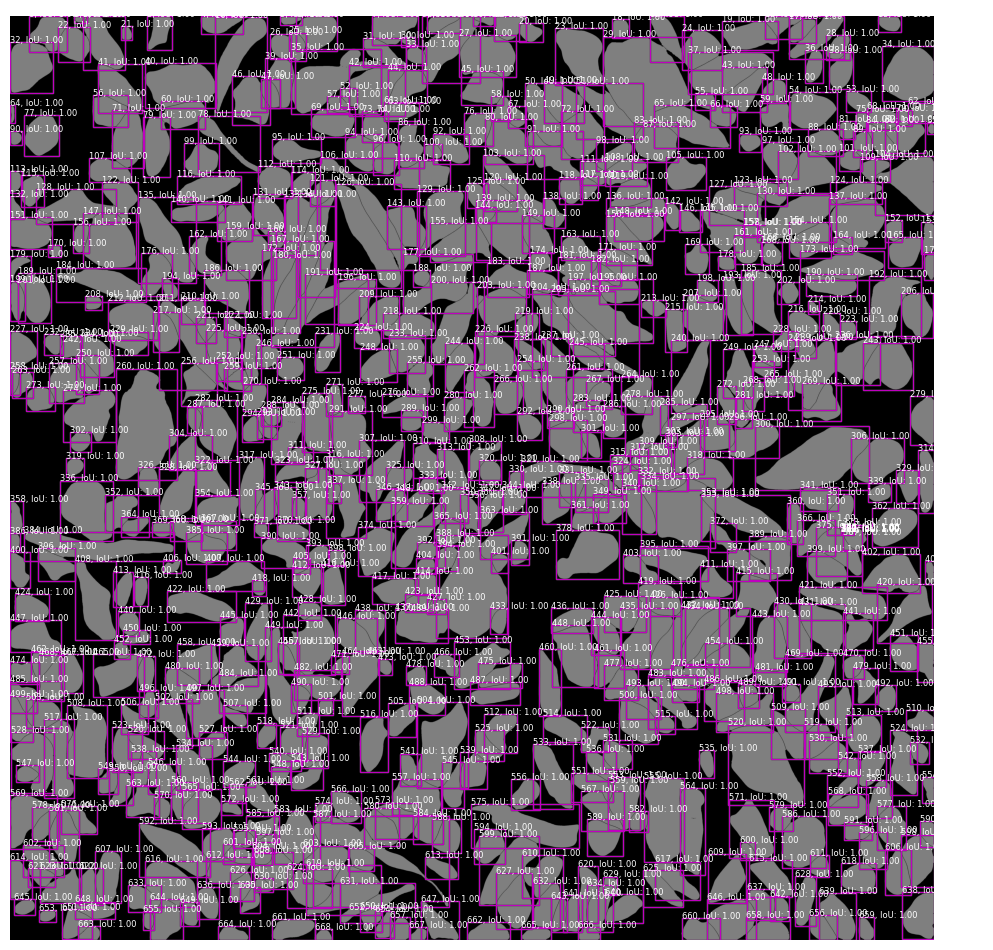

In [135]:
%%time
result.plot()

# And now clean mask and check IoU

In [136]:
mask = remove_small_objects(mask, min_size=2500)

In [137]:
pred = np.zeros(mask.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(model_output_cleaned))):
    segment = model_output_cleaned == segment_ID 
    eroded_segment = binary_erosion(segment)
    pred += eroded_segment.astype(np.uint8)

  0%|          | 0/769 [00:00<?, ?it/s]

#### Difference between cleaned and gt

In [129]:
viewer = napari.Viewer()
viewer.add_image(pred, blending = 'additive')
viewer.add_image(true, blending = 'additive')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'true' at 0x7fb854d7b820>

In [138]:
%%time
result = umetrics.calculate(true, pred)

CPU times: user 49.3 s, sys: 8.1 s, total: 57.4 s
Wall time: 57.6 s


In [ ]:
%%time
result.results

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 14.1 µs


In [ ]:
%%time
result.plot()